# Light Curves

Loading and interacting with `.fits` files.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator

import numpy as np
import pandas as pd

import astropy.io.fits as pf

In [26]:
def rebin(arr,new_shape):

    ''''
    Function to bin the data. 

    '''
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
        new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


def process_lc(lcfile, args):
    '''
    Function to plot the TESS LCs.
    Uses the PDCSAP flux - processed by the TESS pipeline to have some of the systematics removed. 

    Input
    ------
    lcfile : path to the fits file.

    Output
    ------
    Figure showing the TESS LC for a given TIC ID. Showing the binned and unbinned data. 

    '''

    # open the file in context manager
    with pf.open(lcfile) as hdul: # file
        print(hdul.info())

        ## import all the header information,
        tic     = int(hdul[0].header['TICID'])
        print('Reading data for TIC{}'.format(tic))

        d       = hdul[1].data
        t       = d['TIME']
        f1      = d['SAP_FLUX']
        fbkg     = d['SAP_BKG']
        f1      /= np.nanmedian(f1)
        f01     = d['SAP_FLUX']
        f2      = d['PDCSAP_FLUX']  # the processed flux
        f2      /= np.nanmedian(f2)
        f02     = d['PDCSAP_FLUX']

        ## bin data
        N       = len(t)
        n       = int(np.floor(N/args["binfac"])*args["binfac"])
        X       = np.zeros((2,n))
        X[0,:]  = t[:n]
        X[1,:]  = f02[:n]
        Xb      = rebin(X, (2,int(n/args["binfac"])))
        time_binned    = Xb[0]
        flux_binned    = Xb[1]

        time_binned -= time_binned[0]


        q       = d['QUALITY']     # I use these to plot the centroid positions to identify false positives but you probably dom't need them.
        x1      = d['MOM_CENTR1']
        x1      -= np.nanmedian(x1)
        y1      = d['MOM_CENTR2']
        y1      -= np.nanmedian(y1)
        x2      = d['POS_CORR1']
        x2      -= np.nanmedian(x2)
        y2      = d['POS_CORR2']
        y2      -= np.nanmedian(y2)

        l       = (q>0)  
        l2      = (q<=0) # can also plot the removed data points if you care about that
        
        t0      = t[0]  # make the time start at 0 (so that the timeline always runs from 0 to 27.8 days)
        t       -= t0

        tic     = int(hdul[0].header['TICID'])
        sec     = int(hdul[0].header['SECTOR'])
        cam     = int(hdul[0].header['CAMERA'])
        chi     = int(hdul[0].header['CCD'])
        tessmag = hdul[0].header['TESSMAG']
        teff    = hdul[0].header['TEFF']
        srad    = hdul[0].header['RADIUS']
        # can verify these with astroquery...
        print(f"TIC {tic}, Sector {sec}, Camera {cam}, CCD {chi}, TESSmag {tessmag}, Teff {teff}, Radius {srad}")

        scc     = '%02d%1d%1d' % (sec,cam,chi)
        print(f"naming convention {scc}")


    # ------------------------------------------
    # plot the whole LC - binned and unbinned
    # ------------------------------------------

    ## define the plotting area
    fig, ax = plt.subplots(figsize=(16,5))
    plt.subplots_adjust(left=0.01, right=0.99, top=0.95, bottom=0.05)

    ## plot the binned and unbinned LC
    ax.plot(t[l2],f2[l2], color = 'royalblue', marker = 'o', markersize=1, lw = 0, label = 'unbinned')
    # ax.plot(t[l2], f1[l2], color = 'darkorange', marker = 'o', markersize=1, lw = 0, label = 'unprocessed')
    ax.plot(time_binned,flux_binned, color = 'white', marker = 'o', markersize=2, lw = 0, label = 'binned')

    ## define that length on the x axis - I don't want it to display the 0 point
    delta_flux = np.nanmax(f2[l2]) - np.nanmin(f2[l2]) 

    ## set the y lim. 
    percent_change = delta_flux * 0.1  
    ax.set_ylim(np.nanmin(f2[l2]) - percent_change, np.nanmax(f2[l2]) + percent_change)
    
    ## label the axis.
    ax.xaxis.set_label_coords(0.063, 0.06) # position of the x-axis label 

    ## define tick marks/axis parameters

    minorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(minorLocator)
    ax.tick_params(direction='in', which ='minor', colors='w',length=3, labelsize=13)

    minorLocator = AutoMinorLocator()
    ax.yaxis.set_minor_locator(minorLocator)
    ax.tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    ax.tick_params(axis="y",direction="in", pad= -30, color = 'white', labelcolor='white')
    ax.tick_params(axis="x",direction="in", pad= -17, color = 'white', labelcolor='white')   

    ax.set_xlabel("Time (days)",fontsize = 10, color = 'white')


    # ax.set_axis_bgcolor("#03012d")  # depending on what version of Python you're using.
    ax.set_facecolor("#03012d")

    ## save the image
    im_name = 'tess%09d_scc%04s_LC.png' % (tic,scc)
    path = "/mnt/zfsusers/shreshth/pht_project/data/examples"
    plt.savefig('%s/%s' % (path, im_name), format='png')
    plt.show()


Filename: /mnt/zfsusers/shreshth/pht_project/data/TESS/Sector1/light_curves/two_min/tess2018206045859-s0001-0000000008195886-0120-s_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      44   ()      
  1  LIGHTCURVE    1 BinTableHDU    167   20076R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
  2  APERTURE      1 ImageHDU        49   (11, 11)   int32   
None
Reading data for TIC8195886
TIC 8195886, Sector 1, Camera 1, CCD 1, TESSmag 9.85200024, Teff 5704.0, Radius 1.12254
naming convention 0111


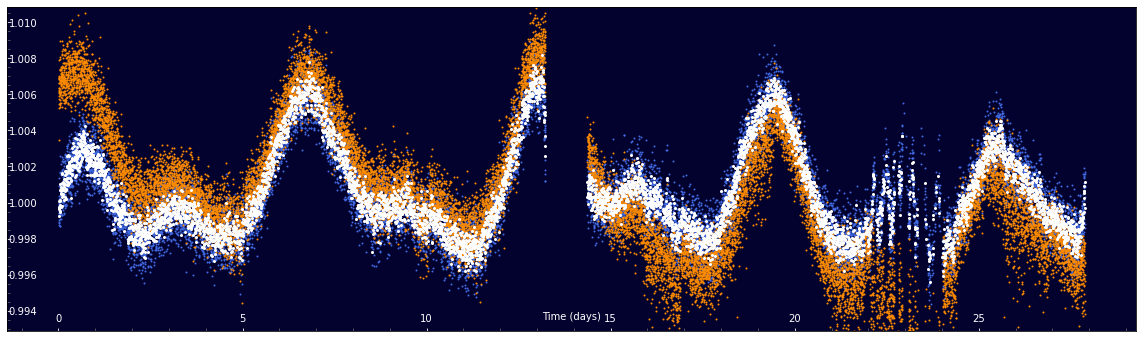

In [27]:
args = {"binfac":3}
lc_file = "/mnt/zfsusers/shreshth/pht_project/data/TESS/Sector1/light_curves/two_min/tess2018206045859-s0001-0000000008195886-0120-s_lc.fits"
process_lc(lc_file, args)
